# Delay Embeddings

This notebook demonstrates the use of delay embeddings in quantum reservoir computing.

---

This file is part of the `QuantumReservoirPy` project.

Last Updated: `2023-09-18`

Using Version: `0.2`

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from qreservoirpy.plot import state_plotter
from qreservoirpy.reservoirs import Static

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity, KNeighborsClassifier

---

## Creating the Reservoir

We will use a `Static` reservoir with a random unitary and read/write to 2 qubits. We will also incorporate 3 ancilliary qubits into our reservoir.

In [2]:
sequence = [0, 1, 1, 0] * 90

num_qubits = 5
operator = random_unitary(2 ** num_qubits, seed=417)

backend = AerSimulator()

During every step in our reservoir, we will initialize the first qubit to our current step in the sequence, and the second qubit to the preceding step in the sequence. 

In [3]:
class DelayEmbeddingReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
        self.preceding_timestep = 0
    
    def during(self, circuit, timestep):
        circuit.measure([0, 1])
        circuit.initialize(str(timestep) + str(self.preceding_timestep), [0, 1])
        self.preceding_timestep = timestep
        circuit.append(operator, circuit.qubits)
    

Create and run the reservoir on the timeseries.

In [4]:
res = DelayEmbeddingReservoir(n_qubits=num_qubits, backend=backend)
data = res.run(timeseries=sequence)

---

## Results

Since we measured 2 qubits during every step in the sequence, we have 2 features to work with. `QuantumReservoirPy` has a convenient function `plot.state_plotter` to visualize multiple features side-by-side.

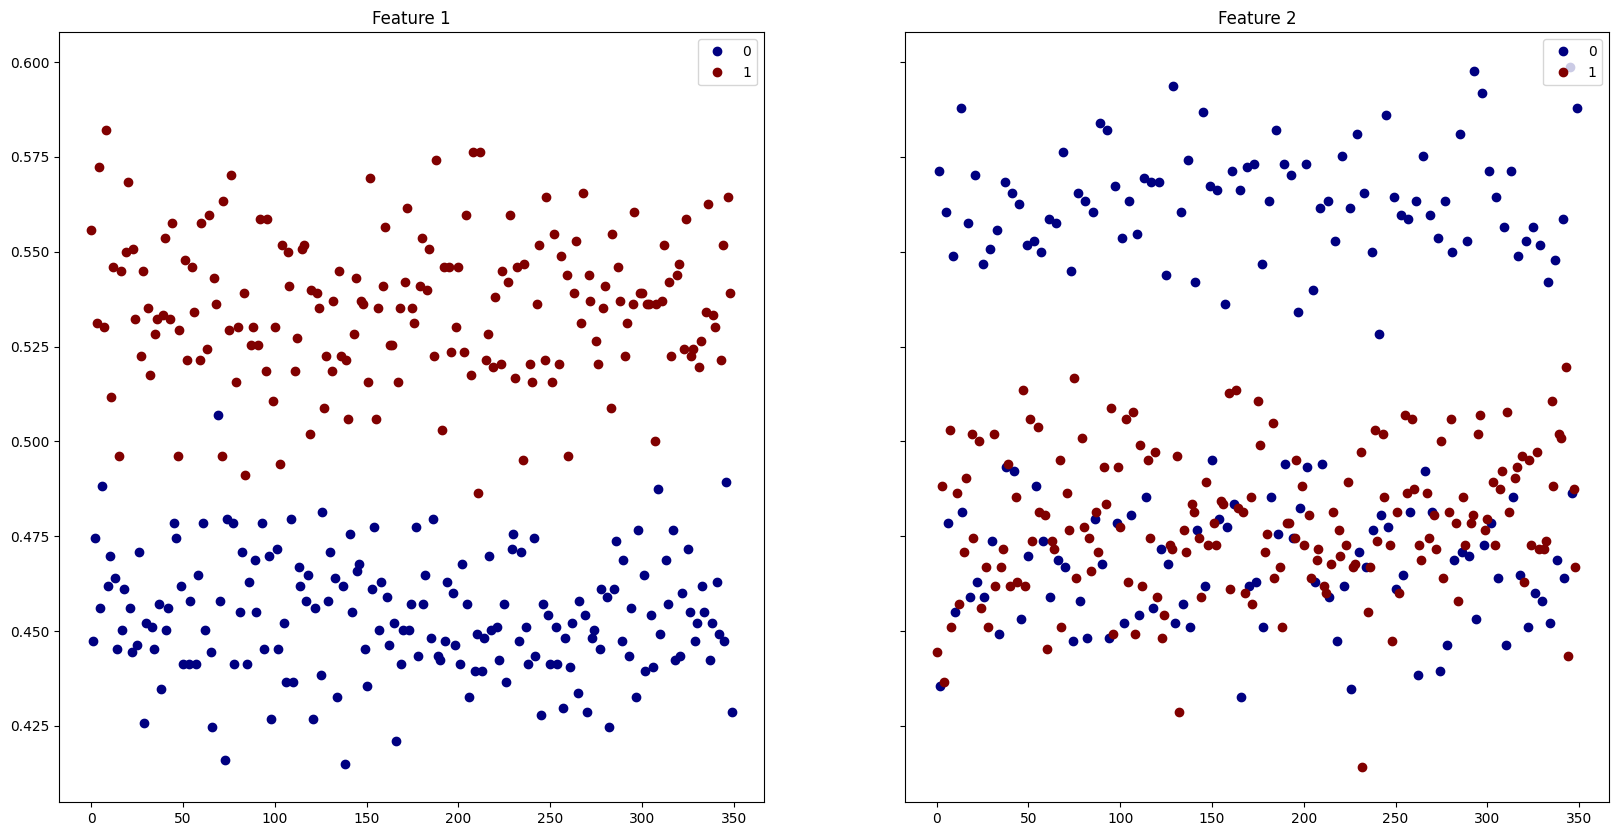

In [5]:
warmup = 10
x = data[warmup:]
y = sequence[warmup:]

fig, axs = state_plotter(x, y)

We can also plot the 2 features together.

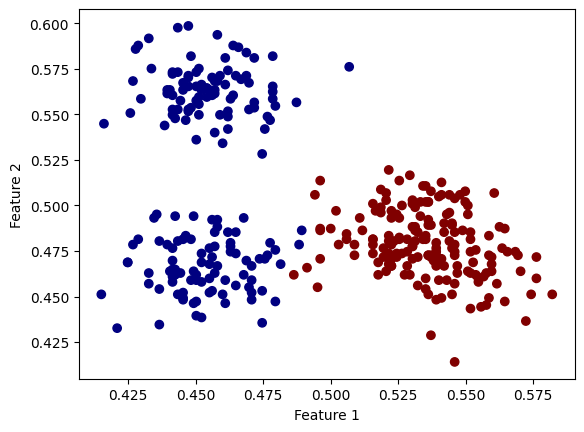

In [6]:
cmap = plt.get_cmap('jet', len(np.unique(y)))
plt.scatter(x[:, 0], x[:, 1], cmap=cmap, c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

The features produced by this reservoir appear to properly distinguish the parts of the sequence.

We can train and evaluate a KNN classifier on this data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=171)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
print("KNN Classifier Score:", model.score(X_test, y_test))

KNN Classifier Score: 1.0


This score indicates a good fit on the data.

---

## Making Predictions

We can use the `predict` method provided for `Static` reservoirs to make predictions from the sequence.

Predicting...: 100%|██████████| 40/40 [01:47<00:00,  2.69s/it]


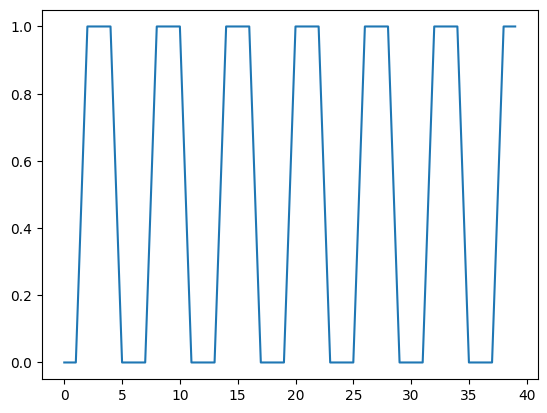

In [8]:
predictions = res.predict(
    num_pred=40,
    model=model,
    from_series=sequence,
    shots=10000
)

pred_plt = plt.plot(predictions)

The predictions are stable but do not properly follow the original sequence.

---

## Comparison with Standard Quantum Reservoir Computing

Constructing a standard quantum reservoir without delay embedding, we can determine the effect of using delay embeddings. See [1Qbit.ipynb](./1Qbit.ipynb) for details on the construction of this.

In [9]:
standard_num_qubits = 4
standard_operator = random_unitary(2 ** standard_num_qubits, seed=416)

class StandardReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep):
        circuit.measure(0)
        circuit.initialize(str(timestep), 0)
        circuit.append(standard_operator, circuit.qubits)

standard_res = StandardReservoir(n_qubits=standard_num_qubits, backend=backend)
standard_data = standard_res.run(timeseries=sequence, shots=10000)

We can plot the results of running the same sequence through our standard reservoir.

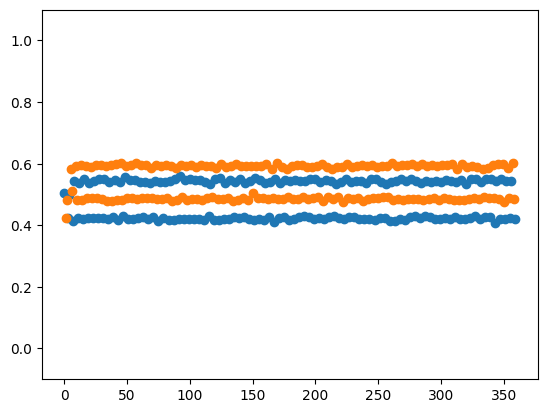

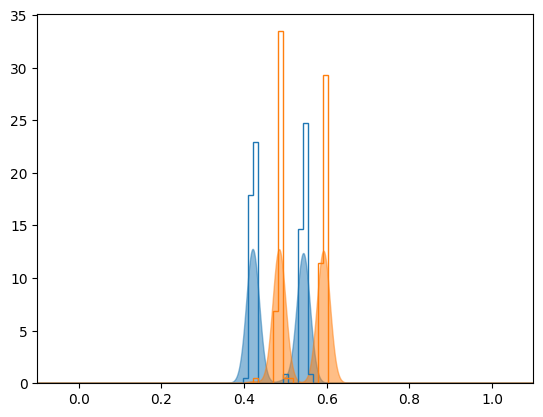

In [10]:
plt.figure()
for category in np.unique(sequence):
    mask = category == sequence
    plt.plot(np.arange(len(standard_data))[mask], standard_data[mask], marker='o', lw=0)
plt.ylim(-0.1, 1.1)
plt.show()

plt.figure()
x_plot = np.linspace(-0.5, 1.5, 10000, endpoint=True)
for i, category in enumerate(np.unique(sequence)):
    colour = 'C' + str(i)
    mask = category == sequence

    plt.hist(
        standard_data[mask],
        density=True,
        bins=np.linspace(-0.1, 1.1, 100, endpoint=True),
        histtype='step',
        color=colour
    )
    
    kde = KernelDensity(bandwidth=1.5e-2, kernel='gaussian')
    kde.fit(standard_data[mask].reshape(-1, 1))
    logprob = kde.score_samples(x_plot.reshape(-1, 1))
    plt.fill_between(x_plot, np.exp(logprob), alpha=0.5, color=colour)
    
plt.xlim(-0.1, 1.1)
plt.show()

The standard reservoir is able to distinguish between parts of the sequence.

We can train and evaluate a similar KNN classifier on the data produced by the standard reservoir.

In [11]:
W_train, W_test, z_train, z_test = train_test_split(standard_data[warmup:], y, test_size=0.33, random_state=171)

standard_model = KNeighborsClassifier(n_neighbors=3)
standard_model.fit(W_train, z_train)
print("KNN Classifier Score Using Standard Reservoir:", standard_model.score(W_test, z_test))

KNN Classifier Score Using Standard Reservoir: 1.0


This score indicates a very good fit on the data.

Predicting...: 100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


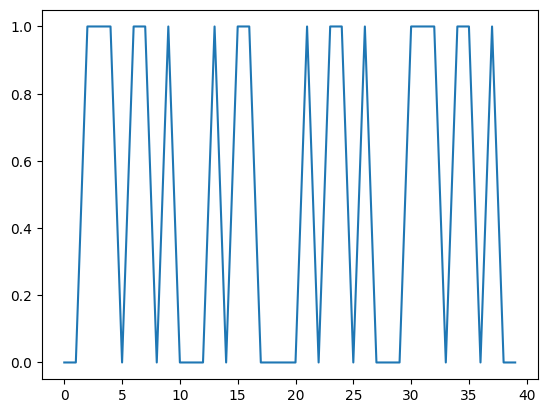

In [12]:
standard_predictions = standard_res.predict(
    num_pred=40,
    model=standard_model,
    from_series=sequence,
    shots=10000
)

standard_pred_plt = plt.plot(standard_predictions)

The predictions produced by the standard reservoir are less stable when compared to using delay embeddings.